## Predict a global signal with the pretrained emulator

In [1]:
import VeryAccurateEmulator as VAE

In [2]:
emulator = VAE.emulator.DirectEmulator()
emulator.load_model()  # load pretrained emulator. Use the model_path kwarg to load other models.

2022-03-19 13:19:54.792833: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-19 13:19:54.792947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thinkpad-ubuntu): /proc/driver/nvidia/version does not exist
2022-03-19 13:19:54.795484: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
emulator.emulator.summary()

Model: "Emulator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 em_input (InputLayer)       [(None, 7)]               0         
                                                                 
 em_hidden_layer_0 (Dense)   (None, 288)               2304      
                                                                 
 em_hidden_layer_1 (Dense)   (None, 352)               101728    
                                                                 
 em_hidden_layer_2 (Dense)   (None, 288)               101664    
                                                                 
 em_hidden_layer_3 (Dense)   (None, 224)               64736     
                                                                 
 dense_16 (Dense)            (None, 451)               101475    
                                                                 
Total params: 371,907
Trainable params: 371,907
Non-traina

In [4]:
# access the input parameters and their order
print(emulator.par_labels)

['fstar', 'Vc', 'fx', 'tau', 'alpha', 'nu_min', 'Rmfp']


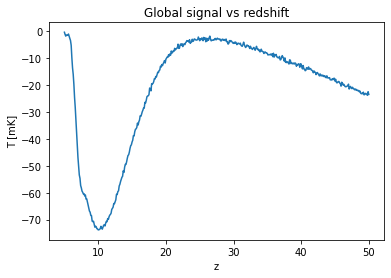

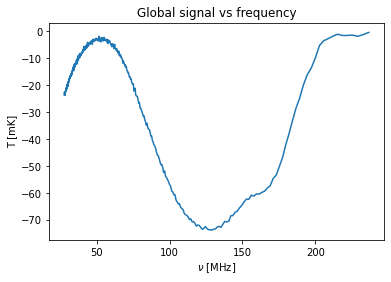

In [5]:
params = [0.0003, 4.2, 0, 0.055, 1.0, 0.1, 10]  # in the order given in the above cell

# alternatively, params can be a (N, 7)-numpy array, where N is the number of different cases you want to emulate at once.
# In that case, the output is a (N, 451)-numpy array. 
# For example, if you have a csv file with 500 cases organized in a 500x7-table, just do 
# params = np.loadtxt(<filepath>)

global_signal = emulator.predict(params)  # emulate the global signal

import matplotlib.pyplot as plt
redshifts = emulator.redshifts  # an array of length 451 with redshifts 5-50:0.1
plt.figure()
plt.plot(redshifts, global_signal)
plt.title('Global signal vs redshift')
plt.xlabel('z')
plt.ylabel('T [mK]')
plt.show()

frequencies = emulator.frequencies  # an array of length 451 with equivalent frequencies
plt.figure()
plt.plot(frequencies, global_signal)
plt.title('Global signal vs frequency')
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel('T [mK]')
plt.show()

In [6]:
import numpy as np
err = emulator.test_error() # compute the relative error, with no input arguments, this computes the error on
# the same test set as used in the paper

# compute the absolute error in the frequency range 50-100 MHz, must set relative to False
abs_err = emulator.test_error(relative=False, flow=50, fhigh=100)
print('Mean relative rms error:', np.mean(err))
print('Mean rms error in mK in the band 50-100 MHz:', np.mean(abs_err))

# since we used no input arguments, we are testing the pretrained model on the test set in the paper. Thus, the
# results should match those given in Table 1 of the paper.

Mean relative rms error: 0.3434216
Mean rms error in mK in the band 50-100 MHz: 0.49636057


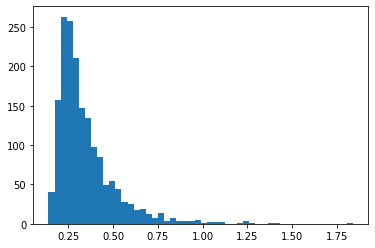

In [7]:
# Histogram of errors, should look like Figure 2 of the paper
plt.hist(err, bins=50)
plt.show()

## Training a new model

In [8]:
# instantiate the 21cmVAE class
custom_model = VAE.emulator.DirectEmulator(hidden_dims=[64, 128], activation_func="relu")
custom_model.emulator.summary()

Model: "emulator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                512       
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 451)               58179     
                                                                 
Total params: 67,011
Trainable params: 67,011
Non-trainable params: 0
_________________________________________________________________


In [9]:
# compile model
import tensorflow as tf

loss_fcn = VAE.emulator.relative_mse_loss(custom_model.signal_train)  # loss function for training
learning_rate = 0.01
opt = tf.keras.optimizers.Adam(learning_rate)

custom_model.emulator.compile(optimizer=opt, loss=loss_fcn)

In [10]:
# define callbacks (optional)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, min_delta=1e-5, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.7, verbose=1, min_delta=1e-4)

cb = [early_stopping, reduce_lr]

In [11]:
loss, val_loss = custom_model.train(epochs=50, callbacks=cb)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.004899999825283885.
Epoch 23: early stopping


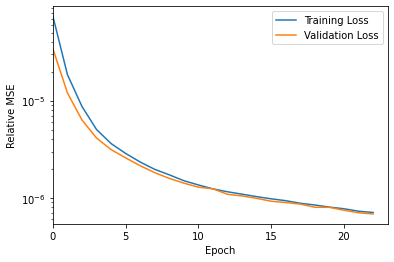

In [12]:
plt.figure()
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.yscale("log")
plt.ylabel("Relative MSE")
plt.xlabel("Epoch")
plt.xlim(0, len(loss))
plt.show()

In [13]:
custom_err = custom_model.test_error() 
# How does this model compare to the pretrained model?
print('Mean relative rms error of pretrained model:', np.mean(err))
print('Mean relative rms error of custom model:', np.mean(custom_err))

# As expected, since we picked random hyperparameters and only trained for 50 epochs ...

Mean relative rms error of pretrained model: 0.3434216
Mean relative rms error of custom model: 2.1928825


## The Autoencoder-Based Emulator

The Autoencoder-based Emulator (see Appendix A) has it's own class. It works similarly to the other emulator and has mostly the same methods.

In [14]:
ae_em = VAE.emulator.AutoEncoderEmulator()
ae_em.load_model()
ae_em.emulator.summary()
ae_em.autoencoder.summary()
ae_em.autoencoder.encoder.summary()
ae_em.autoencoder.decoder.summary()

Model: "AE_Emulator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 em_input (InputLayer)       [(None, 7)]               0         
                                                                 
 em_hidden_layer_0 (Dense)   (None, 352)               2816      
                                                                 
 em_hidden_layer_1 (Dense)   (None, 352)               124256    
                                                                 
 em_hidden_layer_2 (Dense)   (None, 352)               124256    
                                                                 
 em_hidden_layer_3 (Dense)   (None, 224)               79072     
                                                                 
 em_autoencoder (Dense)      (None, 9)                 2025      
                                                                 
Total params: 332,425
Trainable params: 332,425
Non-tra

In [15]:
ae_em_error = ae_em.test_error()
print('Relative rms error for direct emulator is:', np.mean(ae_em_error))

Relative rms error for direct emulator is: 0.3880626


In [18]:
custom_ae_em = VAE.emulator.AutoEncoderEmulator(
    latent_dim=22, enc_hidden_dims=[32, 64], dec_hidden_dims=[64, 32], em_hidden_dims=[32, 128, 256]
)
custom_ae_em.emulator.summary()
custom_ae_em.autoencoder.summary()
custom_ae_em.autoencoder.encoder.summary()
custom_ae_em.autoencoder.decoder.summary()

Model: "ae_emualtor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 32)                256       
                                                                 
 dense_29 (Dense)            (None, 128)               4224      
                                                                 
 dense_30 (Dense)            (None, 256)               33024     
                                                                 
 dense_31 (Dense)            (None, 22)                5654      
                                                                 
Total params: 43,158
Trainable params: 43,158
Non-trainable params: 0
_________________________________________________________________
Model: "auto_encoder_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)      

In [21]:
learning_rate = 0.01
opt = tf.keras.optimizers.Adam(learning_rate)

ae_loss_fcn = VAE.emulator.relative_mse_loss(custom_model.signal_train)  # loss function for training
em_loss_fcn = tf.keras.metrics.mean_squared_error

custom_ae_em.autoencoder.compile(optimizer=opt, loss=ae_loss_fcn)
custom_ae_em.emulator.compile(optimizer=opt, loss=em_loss_fcn)

ae_loss, ae_val_loss, em_loss, em_val_loss = custom_ae_em.train(epochs=30)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

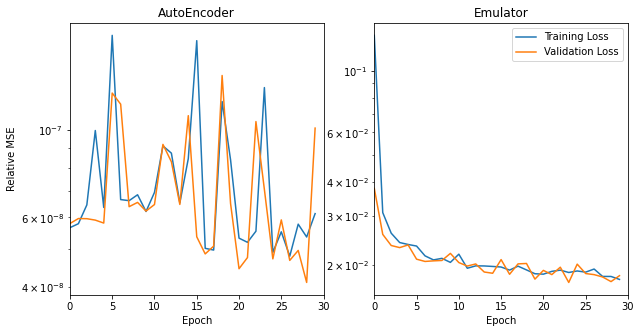

In [25]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2, sharex=True)
ax1, ax2 = axs

ax1.plot(ae_loss, label="Training Loss")
ax1.plot(ae_val_loss, label="Validation Loss")
ax1.set_ylabel("Relative MSE")
ax1.set_title("AutoEncoder")

ax2.plot(em_loss, label="Training Loss")
ax2.plot(em_val_loss, label="Validation Loss")
ax2.set_title("Emulator")
ax2.legend()

plt.setp(axs, yscale="log", xlim=(0, len(ae_loss)), xlabel="Epoch")
plt.show()

In [26]:
custom_autoencoder_em_err = custom_ae_em.test_error()

# How does this model compare to the pretrained model?
print('Mean relative rms error of pretrained direct emulator:', np.mean(ae_em_error))
print('Mean relative rms error of custom direct emulator:', np.mean(custom_autoencoder_em_err))

# As expected ...

Mean relative rms error of pretrained direct emulator: 0.3880626
Mean relative rms error of custom direct emulator: 2.0685136
